In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# IMPORTS
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# DIRECTORIES
DIRECTORY = '../input/mendeley-and-sdnet/Mixed_Dataset/'
TRAIN_DIR = os.path.join(DIRECTORY, 'train')
VAL_DIR = os.path.join(DIRECTORY, 'val')
TEST_DIR = os.path.join(DIRECTORY, 'test')


In [4]:
# HYPERPARAMETERS
learning_rate = 0.0001
BATCH_SIZE = 32
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

In [5]:
# ASSIGNING DATASET TO VARIABLE
TRAIN_IT = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
VAL_IT = image_dataset_from_directory(VAL_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
TEST_IT = image_dataset_from_directory(TEST_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 33690 files belonging to 2 classes.
Found 12731 files belonging to 2 classes.
Found 12696 files belonging to 2 classes.


In [6]:
# DATA AUGMENTATION
DATA_AUG = tf.keras.Sequential([ tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3) ])

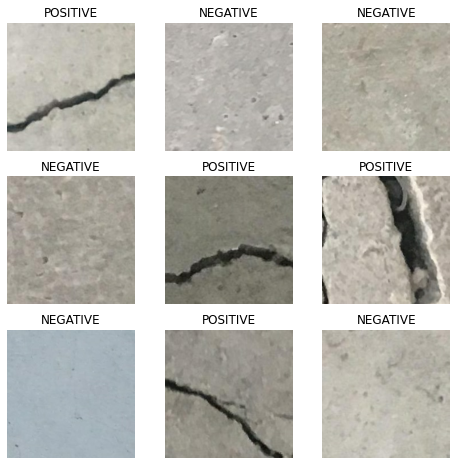

In [7]:
# DATA BEFORE AUGMENTATION
CLASSES = TRAIN_IT.class_names

plt.figure(figsize=(8, 8))
for images, labels in TRAIN_IT.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

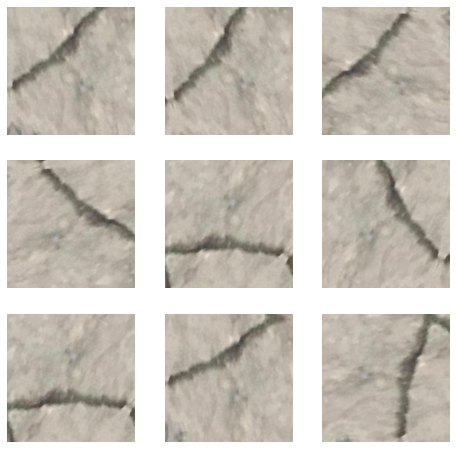

In [8]:
# DATA AFTER AUGMENTATION
for image, _ in TRAIN_IT.take(1):
  plt.figure(figsize=(8, 8))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = DATA_AUG(tf.expand_dims(first_image, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_IT = TRAIN_IT.prefetch(buffer_size=AUTOTUNE)
VAL_IT = VAL_IT.prefetch(buffer_size=AUTOTUNE)
TEST_IT = TEST_IT.prefetch(buffer_size=AUTOTUNE)

In [10]:
INITIAL_MODEL = tf.keras.applications.inception_v3.InceptionV3(input_shape= INPUT_SHAPE, include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [11]:
INITIAL_MODEL.trainable = False

In [12]:
INITIAL_MODEL.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
pred_layer = tf.keras.layers.Dense(1,activation='sigmoid')

In [14]:
input = tf.keras.Input(shape= INPUT_SHAPE)
x = DATA_AUG(input)
x = tf.keras.applications.inception_v3.preprocess_input(input)
x = INITIAL_MODEL(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
x = tf.keras.layers.Dropout(0.3)(x)
output = pred_layer(x)
model = tf.keras.Model(input, output)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
              metrics=['accuracy','Precision', 'Recall'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [17]:
epochs = 10
history = model.fit(TRAIN_IT, epochs=epochs, validation_data=VAL_IT)

Epoch 1/10
1053/1053 [==============================] - 330s 304ms/step - loss: 0.3559 - accuracy: 0.8403 - precision: 0.8486 - recall: 0.8879 - val_loss: 0.1452 - val_accuracy: 0.9489 - val_precision: 0.9846 - val_recall: 0.9328
Epoch 2/10
1053/1053 [==============================] - 70s 67ms/step - loss: 0.1568 - accuracy: 0.9429 - precision: 0.9784 - recall: 0.9204 - val_loss: 0.1166 - val_accuracy: 0.9542 - val_precision: 0.9863 - val_recall: 0.9398
Epoch 3/10
1053/1053 [==============================] - 70s 66ms/step - loss: 0.1309 - accuracy: 0.9493 - precision: 0.9790 - recall: 0.9316 - val_loss: 0.1053 - val_accuracy: 0.9576 - val_precision: 0.9861 - val_recall: 0.9455
Epoch 4/10
1053/1053 [==============================] - 70s 66ms/step - loss: 0.1200 - accuracy: 0.9524 - precision: 0.9783 - recall: 0.9379 - val_loss: 0.0991 - val_accuracy: 0.9588 - val_precision: 0.9856 - val_recall: 0.9479
Epoch 5/10
1053/1053 [==============================] - 70s 66ms/step - loss: 0.1129 -

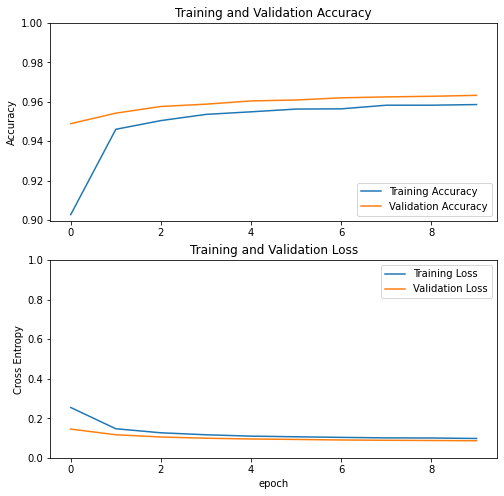

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
INITIAL_MODEL.trainable = True

In [20]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in INITIAL_MODEL.layers[:fine_tune_at]:
  layer.trainable =  False

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy','Precision','Recall'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [23]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(TRAIN_IT,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=VAL_IT)

Epoch 10/20
1053/1053 [==============================] - 145s 129ms/step - loss: 0.0868 - accuracy: 0.9634 - precision: 0.9746 - recall: 0.9611 - val_loss: 0.0512 - val_accuracy: 0.9768 - val_precision: 0.9902 - val_recall: 0.9726
Epoch 11/20
1053/1053 [==============================] - 133s 126ms/step - loss: 0.0540 - accuracy: 0.9767 - precision: 0.9871 - recall: 0.9720 - val_loss: 0.0537 - val_accuracy: 0.9785 - val_precision: 0.9856 - val_recall: 0.9799
Epoch 12/20
1053/1053 [==============================] - 133s 126ms/step - loss: 0.0419 - accuracy: 0.9829 - precision: 0.9902 - recall: 0.9798 - val_loss: 0.0734 - val_accuracy: 0.9766 - val_precision: 0.9956 - val_recall: 0.9668
Epoch 13/20
1053/1053 [==============================] - 133s 126ms/step - loss: 0.0316 - accuracy: 0.9881 - precision: 0.9929 - recall: 0.9862 - val_loss: 0.0828 - val_accuracy: 0.9748 - val_precision: 0.9732 - val_recall: 0.9868
Epoch 14/20
1053/1053 [==============================] - 134s 127ms/step - l

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

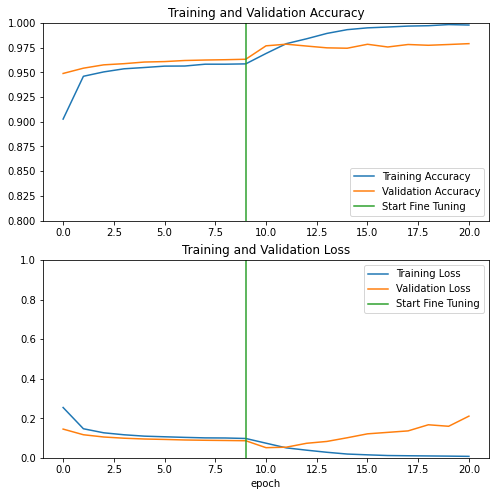

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy, precision, recall = model.evaluate(TEST_IT)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

397/397 [==============================] - 89s 219ms/step - loss: 0.1871 - accuracy: 0.9812 - precision: 0.9874 - recall: 0.9823
Test accuracy : 0.9811751842498779
Test precision : 0.9874445199966431
Test recall : 0.9823366403579712


In [27]:
f1_score = (2*precision*recall)/(precision+recall)
print('F1 Score : ', f1_score)

F1 Score :  0.9848839575039543


Predictions:
 [1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]
Labels:
 [1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]


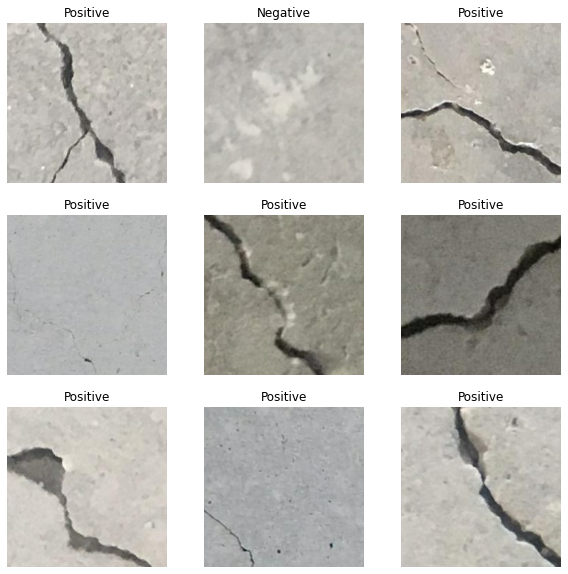

In [28]:
#Retrieve a batch of images from the test set
image_batch, label_batch = TEST_IT.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
class_names = ['Negative', 'Positive']

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [29]:
model.save_weights("inceptionV3_concrete_crack_detection")